##### This notebook contains the analysis used to create the MDA's and CDA

In [1]:
import pandas as pd
import ydata_profiling
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Regime Profile

In [2]:
#reg = ProfileReport(regime)
#reg

#### From the pandas profile report, it can be seen that the following fields are empty (hence removal):
 - under_construction
 - category_data
 - court_rulings_data
 - country_data
##### Note: Removal was done in the transformation (ETL/Transform/transform_files.py)

In [3]:
# general_guidances_data, is 1 json, take a look at the data to establish linkage

# Regime file Analysis

#### In this section we will analyse the regime and perform some data cleansing before creating the necessary MDA's.

In [11]:
# Connect to database
import sqlite3
conn = sqlite3.connect('../Database/sanctions.db') # Remove ../ if used in py code

In [12]:
# Let's check the tables available
pd.read_sql_query("SELECT * FROM sqlite_master", conn)

,type,name,tbl_name,rootpage,sql
0,table,regime_2023_09_12,regime_2023_09_12,2,"CREATE TABLE ""regime_2023_09_12"" (\n""regimes_i..."
1,table,person_one_2023_09_12,person_one_2023_09_12,91,"CREATE TABLE ""person_one_2023_09_12"" (\n""Date_..."
2,table,person_two_2023_09_12,person_two_2023_09_12,3466,"CREATE TABLE ""person_two_2023_09_12"" (\n""fileG..."


In [13]:
# Select latest regime file    <--- Write a function to fetch the latest regime instead of manual assignment !!!!!
regime = pd.read_sql_query('SELECT * from regime_2023_09_12', conn)

In [14]:
conn.close()

#### As can be seen from below, the following fields contain json data :
 - legal_acts_data : `legal_acts_MDA`
 - measures_data : `measures_MDA`
 - guidances_data : `guidances_MDA`
 - general_guidances_data : `general_guidances_MDA`

#### Note: The remaining fields will form `regime_base_MDA`

In [15]:
regime.head(2)

,regimes_id,regimes_type,specification,acronym,notes,special,expiration,amendment,programme,adopted_by.data.id,adopted_by.data.title,country.data.code,country.data.title,legal_acts.data,measures.data,guidances.data,general_guidances.data,category.data.id,category.data.title
0,1,0,Restrictive measures imposed with respect to t...,None,The measures were initially imposed on 15 Octo...,0,nan,1649800800,['AFG'],2,UN,AF,Afghanistan,"[{'id': 1, 'title': 'Council Decision concerni...","[{'id': 28, 'description': 'It is prohibited t...","[{'id': 7, 'title': 'Website of UN Security Co...","[{'id': 1, 'title': 'EU Best Practices for the...",nan,nan
1,2,0,Restrictive measures in view of the situation ...,None,The Council of the EU first adopted restrictiv...,0,1709074800.0,1691013600,['BLR'],1,EU,BY,Belarus,"[{'id': 4, 'title': 'Council Regulation concer...","[{'id': 24, 'description': 'It is prohibited t...","[{'id': 43, 'title': 'Frequently asked questio...","[{'id': 1, 'title': 'EU Best Practices for the...",nan,nan


In [16]:
#### regime.to_json('temp.json', orient='records')

In [10]:
def df_to_formatted_json(df, sep="."):
    """
    The opposite of json_normalize
    """
    result = []
    for idx, row in df.iterrows():
        parsed_row = {}
        for col_label,v in row.items():
            keys = col_label.split(sep)

            current = parsed_row
            for i, k in enumerate(keys):
                if i==len(keys)-1:
                    current[k] = v
                else:
                    if k not in current.keys():
                        current[k] = {}
                    current = current[k]
        # save
        result.append(parsed_row)
    return result

In [11]:
regime_stats = regime.describe()
regime_stats.loc['skew'] = regime.skew()
regime_stats.loc['kurtosis'] = regime.kurtosis()
regime_stats

C:\Users\kwame\AppData\Local\Temp\ipykernel_16956\1747734237.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  regime_stats.loc['skew'] = regime.skew()
C:\Users\kwame\AppData\Local\Temp\ipykernel_16956\1747734237.py:3: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  regime_stats.loc['kurtosis'] = regime.kurtosis()


,regimes_id,regimes_type,specification,acronym,notes,special,expiration,amendment,programme,adopted_by_data_id,adopted_by_data_title,country_data_code,country_data_title,legal_acts_data,measures_data,guidances_data,general_guidances_data,category_data_id,category_data_title
count,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
unique,49,2,48,7,49,2,25,32,32,3,3,34,34,49,49,30,1,5,5
top,1,0,Restrictive measures in relation to the 14 Feb...,None,The measures were initially imposed on 15 Octo...,0,nan,1689804000,[],1,EU,nan,nan,"[{'id': 1, 'title': 'Council Decision concerni...","[{'id': 28, 'description': 'It is prohibited t...",[],"[{'id': 1, 'title': 'EU Best Practices for the...",nan,nan
freq,1,44,2,41,1,42,23,7,16,29,29,5,5,1,1,20,49,44,44
skew,-0.014225,2.713152,NaN,NaN,NaN,2.106276,NaN,-3.700868,NaN,0.749535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kurtosis,-1.128699,5.587755,NaN,NaN,NaN,2.53839,NaN,12.628081,NaN,-1.215409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert columns in "[]" to String

In [12]:
regime["programme"] = regime["programme"].str.strip("[']")

### Correct Data Types for columns

In [13]:
# Categorical
columns_to_category = ["regimes_type", "acronym", "special", "adopted_by_data_id", "adopted_by_data_title", 
                       "adopted_by_data_title", "category_data_id", "category_data_title"]
for column in columns_to_category:
    regime[column] = regime[column].astype("category")    

# Dates
date_fields = ["expiration", "amendment"]
regime[date_fields] = regime[date_fields].apply(pd.to_datetime, unit='s')

In [14]:
#regime.dtypes

### Nulls/Empty values

In [15]:
# Before checking nulls/Empty, let's also classify all the strings ("") 
# and "None" that are empty, to enable a hollistic view of the data

regime = regime.replace("", np.nan).replace("None", np.nan)

In [16]:
# Let's find the % nulls per columns
regime.isnull().mean() * 100

regimes_id                 0.000000
regimes_type               0.000000
specification              0.000000
acronym                   83.673469
notes                      0.000000
special                    0.000000
expiration                46.938776
amendment                  0.000000
programme                 32.653061
adopted_by_data_id         0.000000
adopted_by_data_title      0.000000
country_data_code          0.000000
country_data_title         0.000000
legal_acts_data            0.000000
measures_data              0.000000
guidances_data             0.000000
general_guidances_data     0.000000
category_data_id           0.000000
category_data_title        0.000000
dtype: float64

### Acronym

#### Let's examine the 83% nulls in acronym column

In [17]:
# From analysis it can be argued that using the specification, the acronym can be dervied.
# For example: Any specification relating to violating of Human Rights, will have the acronym "HR". 
# However, considering the situation, I feel the best option is 
# to put the empty fields to "None" to enable future compatability

regime["acronym"] = regime["acronym"].cat.add_categories(['None']).fillna('None')

In [18]:
len(regime.index)

49

In [19]:
# len(df.index) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

len(regime[regime["acronym"].notnull()])

49

In [20]:
regime[regime["acronym"].isnull()]

,regimes_id,regimes_type,specification,acronym,notes,special,expiration,amendment,programme,adopted_by_data_id,adopted_by_data_title,country_data_code,country_data_title,legal_acts_data,measures_data,guidances_data,general_guidances_data,category_data_id,category_data_title


### Expiration

##### As it can be seen, 47.92% of expiration data is null
##### Hence, create a heatmap to see if it's correlated to any other columns to help fill in the empty values

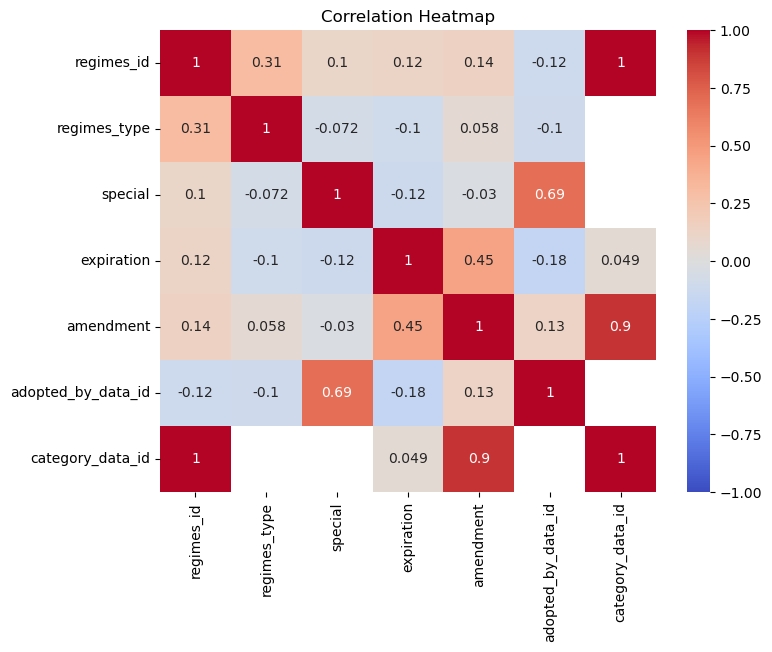

In [23]:
corr_regime = regime[["regimes_id", "regimes_type", "special", "expiration", 
                      "amendment", "adopted_by_data_id", "category_data_id"]]
corr_regime =corr_regime.dropna()
corr_regime = corr_regime.apply(pd.to_numeric, errors='coerce')
corr_matrix = corr_regime.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.title('Correlation Heatmap')

plt.show()


##### From the correlation heatmap, it can be seen that there might be a correlation between expiration and amendment (0.42).
##### Hence, let's examine both data further to reach a conclusion

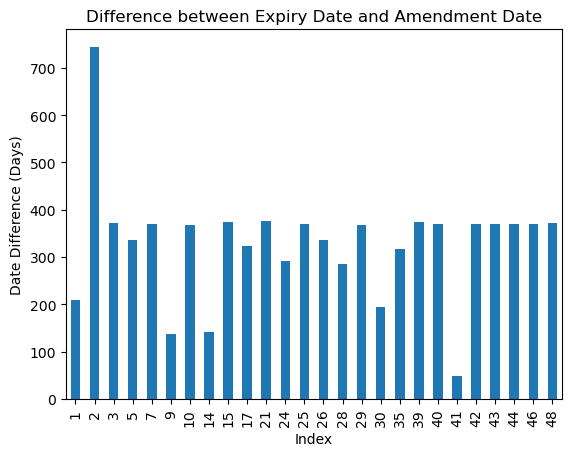

In [21]:
regime["date_difference"] = regime["expiration"] - regime["amendment"]
regime_notnull = regime[regime["date_difference"].notnull()]["date_difference"]
regime_notnull.dt.days.plot(kind="bar")

plt.xlabel("Index")
plt.ylabel("Date Difference (Days)")
plt.title("Difference between Expiry Date and Amendment Date")

plt.show()

# In the results below, the index 2 (Bosnia and Herzegovina) is not an outlier, the sanction was extended

##### Based on the results above, we can use the median of amendment and expiration and use this to populate the missing data in expiration

In [22]:
# Calculate the average of the date_difference and use it to populate the missing fields
average_date_difference = regime["date_difference"].median()
regime["expiration"].fillna(regime["amendment"] + average_date_difference, inplace=True)

# drop unneded column
regime.drop("date_difference", axis=1, inplace=True)

# The alternative to the method above, which in production will need to be done 
# is sourcing the correct expiry dates from online/alternative sources

In [23]:
# Check if all expiration values are populated

# Use len(df.index)  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
regime[regime["expiration"].isnull()].count()[0]

0

#### Programme

##### For the programme it can be seen the values are inline with WITS System country names and the International Standards Organization (ISO) 3-digit alphabetic codes. 
##### Hence, a table was created with the data called "country_code.csv". This table was used to populate the missing programme values

In [24]:
# Check empty values in programme column
len(regime[regime["programme"].isnull()])

16

In [25]:
# For the empty programs let's use the list created for country_codes

country_codes = pd.read_csv("country_code.csv")

In [26]:
# To enable matching with country_code
regime["country_data_title"] = regime["country_data_title"].str.replace("&", "and")

# Join
regime = regime.merge(country_codes, 
                      left_on="country_data_title", 
                      right_on="country_name", how="left")

# Use the value for country_codes when programme is empty
regime["programme"] = regime["programme"].mask(regime["programme"].isnull(), regime["country_codes"])
regime = regime.drop(columns=["country_name" , "country_codes"])

In [27]:
len(regime[regime["programme"].isnull()])

0

In [28]:
# Now let's replace all the fields with "None",  due to not corresponding to any category.

regime = regime.replace("nan", "None").fillna('None')

In [29]:
#EUAQ', 'TAQA

# Clean up and handle this later based on the data.
regime["programme"] = regime["programme"].str.replace("'", "")

In [30]:
regime.head(2)

,regimes_id,regimes_type,specification,acronym,notes,special,expiration,amendment,programme,adopted_by_data_id,adopted_by_data_title,country_data_code,country_data_title,legal_acts_data,measures_data,guidances_data,general_guidances_data,category_data_id,category_data_title
0,1,0,Restrictive measures imposed with respect to t...,None,The measures were initially imposed on 15 Octo...,0,2023-04-16 10:00:00,2022-04-12 22:00:00,AFG,2,UN,AF,Afghanistan,"[{'id': 1, 'title': 'Council Decision concerni...","[{'id': 28, 'description': 'It is prohibited t...","[{'id': 7, 'title': 'Website of UN Security Co...","[{'id': 1, 'title': 'EU Best Practices for the...",None,None
1,2,0,Restrictive measures in view of the situation ...,None,The Council of the EU first adopted restrictiv...,0,2024-02-27 23:00:00,2023-08-02 22:00:00,BLR,1,EU,BY,Belarus,"[{'id': 4, 'title': 'Council Regulation concer...","[{'id': 24, 'description': 'It is prohibited t...","[{'id': 43, 'title': 'Frequently asked questio...","[{'id': 1, 'title': 'EU Best Practices for the...",None,None


In [31]:
# Check if % of nulls/empty values (% can be taken due to size of data)
regime.isnull().mean() * 100

regimes_id                0.0
regimes_type              0.0
specification             0.0
acronym                   0.0
notes                     0.0
special                   0.0
expiration                0.0
amendment                 0.0
programme                 0.0
adopted_by_data_id        0.0
adopted_by_data_title     0.0
country_data_code         0.0
country_data_title        0.0
legal_acts_data           0.0
measures_data             0.0
guidances_data            0.0
general_guidances_data    0.0
category_data_id          0.0
category_data_title       0.0
dtype: float64

# Regime_base MDA

##### Regime_base MDA will consist of all the fields in regime except the json fields

In [32]:
regime_base = regime.copy()

# Drop json columns
regime_base_MDA = regime_base.drop(columns=['legal_acts_data', 'measures_data', 'guidances_data', 'general_guidances_data'])

In [33]:
regime_base_MDA.head(1)

,regimes_id,regimes_type,specification,acronym,notes,special,expiration,amendment,programme,adopted_by_data_id,adopted_by_data_title,country_data_code,country_data_title,category_data_id,category_data_title
0,1,0,Restrictive measures imposed with respect to t...,None,The measures were initially imposed on 15 Octo...,0,2023-04-16 10:00:00,2022-04-12 22:00:00,AFG,2,UN,AF,Afghanistan,None,None


## Legal Acts MDA

In [337]:
def adjust_json_tags(row):
    result = row.replace("{'", '{"').replace(" '", ' "').replace("':", '":').replace("',", '",').replace("'}", '"}')
    return pd.json_normalize(json.loads(result))

def get_nested_json(df, regimes_id, col_to_explode):
    df.loc[:, col_to_explode] = df[col_to_explode].apply(adjust_json_tags)
    #df[col_to_explode] = df[col_to_explode].apply(adjust_json_tags)
    combined_df = pd.concat\
    (
        [row[col_to_explode].assign(regimes_id=row[regimes_id]) for _, row in df.iterrows()], \
        ignore_index=True\
    )
    return combined_df


In [338]:
legal_acts_mda = regime[['regimes_id', 'legal_acts_data']]

legal_acts_mda = get_nested_json(legal_acts_mda, 'regimes_id', 'legal_acts_data')

C:\Users\kwame\AppData\Local\Temp\ipykernel_16956\1859244762.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col_to_explode] = df[col_to_explode].apply(adjust_json_tags)


In [339]:
legal_acts_mda.head(1)

,id,title,number,url,type.data.id,type.data.title,regimes_id
0,1.0,Council Decision concerning restrictive measur...,05.02.2022 consolidated basic legal act - 2011...,https://eur-lex.europa.eu/legal-content/EN/TXT...,1.0,EU Council Decision,1


In [37]:
legal_acts_mda.count()

id                 254
title              254
number             254
url                254
type.data.id       254
type.data.title    254
regimes_id         254
dtype: int64

### Rename

In [38]:
legal_acts_mda = legal_acts_mda.rename(columns={"type.data.id": "type_data_id", 
                                                "type.data.title": "type_data_title"})

In [41]:
legal_acts_mda.columns

Index(['id', 'title', 'number', 'url', 'type_data_id', 'type_data_title',
       'regimes_id'],
      dtype='object')

### Legal Acts MDA Profile

In [42]:
#legal_acts_profile = ProfileReport(legal_acts_mda)
#legal_acts_profile

##### From the profile the data seems to be in good state with no missing data and/or anomalies

In [43]:
legal_acts_mda.head(3)

,id,title,number,url,type_data_id,type_data_title,regimes_id
0,1.0,Council Decision concerning restrictive measur...,05.02.2022 consolidated basic legal act - 2011...,https://eur-lex.europa.eu/legal-content/EN/TXT...,1.0,EU Council Decision,1
1,2.0,Council Regulation concerning restrictive meas...,13.04.2022 consolidated basic legal act - (EU)...,https://eur-lex.europa.eu/legal-content/EN/TXT...,2.0,EU Council Regulation,1
2,79.0,Resolution 1988 (2011),S/RES/1988 (2011),https://undocs.org/S/RES/1988(2011),7.0,UN Security Council Resolution,1


## Measures MDA

In [459]:
with open("../ETL/Extract/Downloaded_Files/regime_2023_08_18.json", encoding="utf-8") as reg: # <------- Adjust when used in code !!
    data = json.load(reg)
file_transformed = pd.json_normalize(data, "data")

In [403]:
measures_data_mda = file_transformed[['id', 'measures.data']].rename(columns={'id': 'regime_id'})

In [404]:
measures_1 = measures_data_mda[["regime_id", "measures.data"]].explode("measures.data")
measures_1 = measures_1.reset_index().drop("index", axis=1)

In [406]:
measures_2 = pd.json_normalize(measures_1["measures.data"])

In [409]:
measures_all = pd.concat([measures_1, measures_2], axis=1)

In [415]:
measures_data_mda = measures_all.drop(columns=["measures.data", "type.data.parent_id"])

measures_data_mda = measures_data_mda.rename(columns={"id": "measures_id", 
                                                      "type.data.id": "data_id", 
                                                      "type.data.icon": "measures_icon", "type.data.title": "measures_title"})

In [419]:
measures_data_mda.head()

,regime_id,measures_id,description,suspend,data_id,measures_icon,measures_title
0,1,28.0,It is prohibited to export arms and related ma...,False,4.0,https://www.sanctionsmap.eu/storage/icons/hYvA...,Arms export
1,1,8.0,All assets of the listed persons and entities ...,False,6.0,https://www.sanctionsmap.eu/storage/icons/bGum...,Asset freeze and prohibition to make funds ava...
2,1,29.0,Member States shall enforce travel restriction...,False,18.0,https://www.sanctionsmap.eu/storage/icons/LUMa...,Restrictions on admission
3,2,24.0,It is prohibited to export arms and related ma...,False,4.0,https://www.sanctionsmap.eu/storage/icons/hYvA...,Arms export
4,2,2.0,All assets of the listed persons and entities ...,False,6.0,https://www.sanctionsmap.eu/storage/icons/bGum...,Asset freeze and prohibition to make funds ava...


## Guidances MDA

In [240]:
guidances_data_mda = regime[['regimes_id', "guidances_data"]]

In [241]:
guidances_data_mda = get_nested_json(guidances_data_mda, 'regimes_id', 'guidances_data')

C:\Users\kwame\AppData\Local\Temp\ipykernel_8276\1859244762.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col_to_explode] = df[col_to_explode].apply(adjust_json_tags)


In [41]:
guidances_data.count()

regimes_id        48
guidances_data    48
dtype: int64

In [50]:
# It can be seen attachments.data is in json format
guidances_data_mda.loc[[2]]

,id,title,url,is_direct,attachments.data,regimes_id
2,34.0,Opinion on the release of frozen funds under C...,https://finance.ec.europa.eu/system/files/2021...,1.0,[{'name': '210602-frozen-funds-features-centra...,9


In [58]:
# id is unique, it can be utilised for exploding the columns
guidances_data_mda["id"].is_unique

True

In [242]:
guide_attach = guidances_data_mda[["id", "attachments.data"]]

all_attach = pd.DataFrame()
for index, val in guide_attach.iterrows():
    nt = pd.json_normalize(val[1], errors='ignore')
    nt["id"] = val[0]
    all_attach = pd.concat([all_attach, nt], axis=0)

In [243]:
all_attach = all_attach.rename(columns={"url": "attachment_url"})

In [244]:
# Join
guidances_data_mda = guidances_data_mda.merge(all_attach, on="id", how="left")

In [245]:
guidances_data_mda = guidances_data_mda.drop("attachments.data", axis=1)

In [246]:
# Nulls/Empty
guidances_data_mda.isnull().mean() * 100

id                 0.000000
title              0.000000
url                0.000000
is_direct          0.000000
regimes_id         0.000000
name              44.186047
type              44.186047
size              44.186047
attachment_url    44.186047
dtype: float64

In [ ]:
# As it can be seen, 44.19% the data is empty for attachments, this can be rectified by downloading 
# and storing the data, or scraping the data (but this is not recommended due to various issues)

In [249]:
# Put Nulls/Empty to none
guidances_data_mda["size"] = guidances_data_mda["size"].fillna(0.0)
guidances_data_mda = guidances_data_mda.fillna("None")

In [268]:
# Drop is_direct
guidances_data_mda.head(5)

,id,title,url,is_direct,regimes_id,name,type,size,attachment_url
0,7.0,Website of UN Security Council Sanctions Commi...,https://www.un.org/securitycouncil/sanctions/1988,1.0,1,None,None,0.0,None
1,43.0,Frequently asked questions on sanctions agains...,https://finance.ec.europa.eu/eu-and-world/sanc...,1.0,2,None,None,0.0,None
2,34.0,Opinion on the release of frozen funds under C...,https://finance.ec.europa.eu/system/files/2021...,1.0,9,210602-frozen-funds-features-central-african-r...,application/pdf,272363.0,https://www.sanctionsmap.eu/files/aif19rpigmw2...
3,8.0,Website of UN Security Council Sanctions Commi...,https://www.un.org/securitycouncil/sanctions/2127,1.0,9,None,None,0.0,None
4,27.0,Guidance note on the import and export ban of ...,https://finance.ec.europa.eu/system/files/2020...,1.0,20,190131-guidance-luxury-goods_en.pdf,application/pdf,385275.0,https://www.sanctionsmap.eu/files/9b4l22dxomt4...


In [253]:
#This is DONE !!!!!!!!!!!!!!!

## General Guidances MDA

In [440]:
# The same data is repeated across all the rows, so only select the first row
general_guidances_mda = regime[["regimes_id", "general_guidances_data"]].iloc[[0]]

In [442]:
general_guidances_mda = get_nested_json(general_guidances_mda, 'regimes_id', 'general_guidances_data')

In [443]:
# key for table is ["id", "regimes_id"]
general_guidances_mda.head(5)

,id,title,url,is_direct,attachments.data,regimes_id
0,1,EU Best Practices for the effective implementa...,https://data.consilium.europa.eu/doc/document/...,0,"[{'name': 'ST-10572-2022-INIT_en.pdf', 'type':...",1
1,2,Guidelines on implementation and evaluation of...,http://data.consilium.europa.eu/doc/document/S...,0,"[{'name': 'ST_15598_2017_INIT_EN_Public.pdf', ...",1


In [444]:
general_guide_attach = general_guidances_mda[["id", "regimes_id", "attachments.data"]]

all_attachment = pd.DataFrame()
for index, val in general_guide_attach.iterrows():
    attachment = pd.json_normalize(val[2], errors='ignore')
    attachment["id"] = val[0]
    attachment["regimes_id"] = val[1]
    all_attachment = pd.concat([all_attachment, attachment], axis=0)

In [446]:
all_attachment.head(5)

,name,type,size,url,id,regimes_id
0,ST-10572-2022-INIT_en.pdf,application/pdf,515311,https://www.sanctionsmap.eu/files/607ttzp08coq...,1,1
0,ST_15598_2017_INIT_EN_Public.pdf,application/pdf,410322,https://www.sanctionsmap.eu/files/e1dk1lv5h5c7...,2,1


In [447]:
all_attachment = all_attachment.rename(columns={"url": "attachment_url"})

In [448]:
all_attachment.count()

name              2
type              2
size              2
attachment_url    2
id                2
regimes_id        2
dtype: int64

In [449]:
general_guidances_mda = general_guidances_mda.merge(all_attachment, on=["id", "regimes_id"])

In [450]:
general_guidances_mda = general_guidances_mda.drop("attachments.data", axis=1)

In [307]:
# Note: This table should join each row

In [308]:
# Done